<a href="https://colab.research.google.com/github/awaiskhan005/DATA-SCIENCE-AND-AI-/blob/main/ETH_PRED_FOR_HOURLY_BASIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


                                  Open         High          Low        Close  \
Datetime                                                                        
2023-01-01 00:00:00+00:00  1196.713623  1196.837891  1194.517456  1195.268921   
2023-01-01 01:00:00+00:00  1195.257324  1196.110474  1194.797241  1196.110474   
2023-01-01 02:00:00+00:00  1196.112671  1196.862061  1195.155396  1196.140747   
2023-01-01 03:00:00+00:00  1196.069092  1196.069092  1193.782349  1194.769409   
2023-01-01 04:00:00+00:00  1194.807617  1194.807617  1192.885376  1192.973022   

                             Adj Close   Volume  
Datetime                                         
2023-01-01 00:00:00+00:00  1195.268921        0  
2023-01-01 01:00:00+00:00  1196.110474        0  
2023-01-01 02:00:00+00:00  1196.140747        0  
2023-01-01 03:00:00+00:00  1194.769409  4435456  
2023-01-01 04:00:00+00:00  1192.973022        0  
Epoch 1/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - loss: 0.0081
Epoch 2/50
37

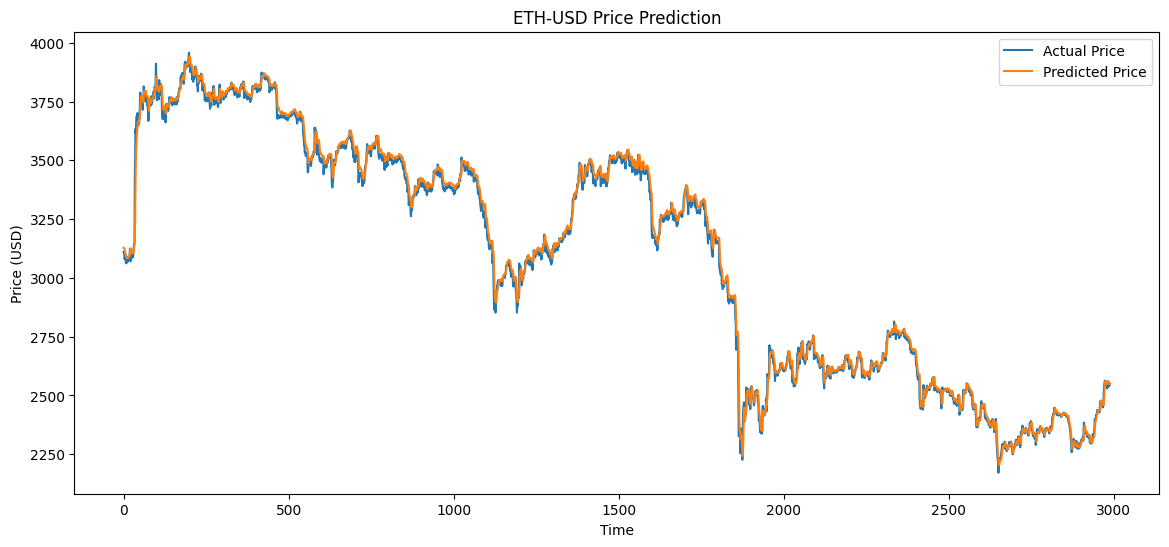

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted ETH-USD Price for the next hour: 2559.5673828125


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

start_date = '2023-01-01'
end_date = '2024-09-21'


data = yf.download('ETH-USD', start=start_date, end=end_date, interval='1h')
print(data.head())

close_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)


def create_dataset(data, time_step=60):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:i+time_step, 0])
        Y.append(data[i+time_step, 0])
    return np.array(X), np.array(Y)


time_step = 60
X, Y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Build the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, batch_size=32, epochs=50)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Inverse transform to get actual values

# Inverse scaling of the true test values
Y_test_actual = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Plot the results: predicted vs actual ETH-USD prices
plt.figure(figsize=(14, 6))
plt.plot(Y_test_actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('ETH-USD Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Predict
last_60_data = scaled_data[-time_step:].reshape(1, time_step, 1)

# Predict the next hour's price
next_hour_prediction = model.predict(last_60_data)

# Inverse the normalization to get the actual price
next_hour_prediction = scaler.inverse_transform(next_hour_prediction)

print(f"Predicted ETH-USD Price for the next hour: {next_hour_prediction[0][0]}")
